## Installations and importations

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import random
%matplotlib ipympl
from ipynb.fs.full.triangle_matching import triangle_matching_fn

### Load images

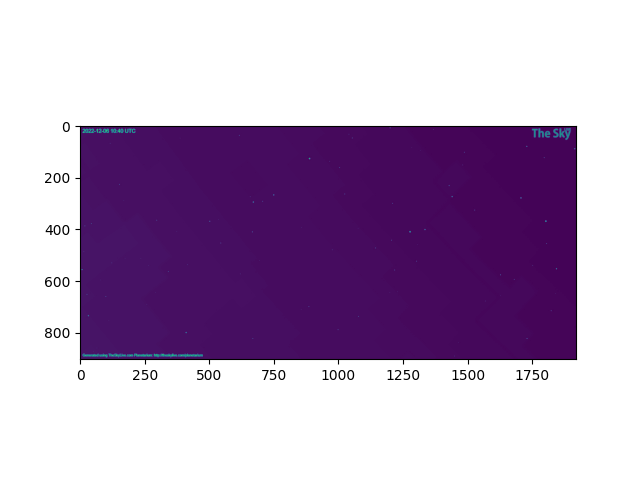

In [2]:
Image_Src_dir = 'SkyLive_8_320_images'
Image_files = os.listdir(Image_Src_dir)

IMAGES = []
for file in Image_files:
    IMAGES.append(cv2.imread(Image_Src_dir+"\\"+file))    
    IMAGES[-1] = cv2.cvtColor(IMAGES[-1], cv2.COLOR_BGR2GRAY)
    IMAGES[-1] = np.array(IMAGES[-1], dtype=np.float_)/255

# Plot(1st image)
plt.figure(1)
plt.imshow(IMAGES[0])
plt.show()

### Crop images if neccessary

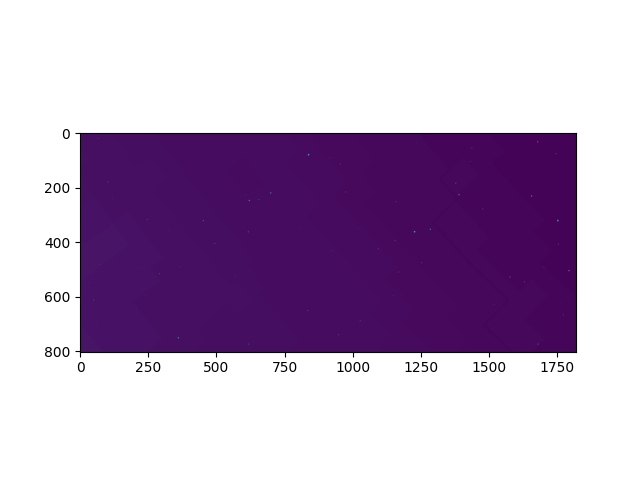

In [3]:
Crop_border = 50
for image_no in range(len(IMAGES)):
    IMAGES[image_no] = IMAGES[image_no][Crop_border:IMAGES[image_no].shape[0]-Crop_border, Crop_border:IMAGES[image_no].shape[1]-Crop_border]

plt.figure(2)
plt.imshow(IMAGES[0])
plt.show()

### Threshold

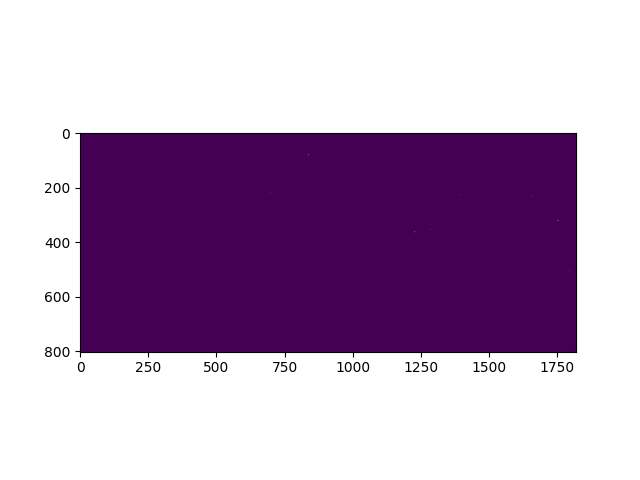

In [4]:
Threshold = 0.8
for image_no in range(len(IMAGES)):
    IMAGES[image_no][IMAGES[image_no] < Threshold] = 0
    #IMAGES[image_no][IMAGES[image_no] >= Threshold] = 1

plt.figure(3)
plt.imshow(IMAGES[0])
plt.show()

### Identify star locations

In [5]:
STARS = [] #Store size and location of all stars

for image_no in range(len(IMAGES)):
    print("Locating stars in Image-",image_no)
    image_copy = np.copy(IMAGES[image_no])

    Star_indices = np.argwhere(image_copy)
    stars = []
    while(Star_indices.shape[0] != 0):
        Rand_pos = Star_indices[random.randrange(Star_indices.shape[0])]

        Up_shift = 0
        Right_shift = 0
        Down_shift = 0
        Left_shift = 0
        #Rand_pos = np.array([615, 1689], dtype=np.int_)        
        while True:
            if(Rand_pos[0]-Up_shift != 0):
                if(np.any(image_copy[Rand_pos[0]-Up_shift, Rand_pos[1]-Left_shift:Rand_pos[1]+Right_shift+1])):
                    Up_shift = Up_shift+1
                    continue
            if(Rand_pos[1]+Right_shift != image_copy.shape[1]-1):
                if(np.any(image_copy[Rand_pos[0]-Up_shift:Rand_pos[0]+Down_shift+1, Rand_pos[1]+Right_shift])):
                    Right_shift = Right_shift+1
                    continue
            if(Rand_pos[0]+Down_shift != image_copy.shape[0]-1):
                if(np.any(image_copy[Rand_pos[0]+Down_shift, Rand_pos[1]-Left_shift:Rand_pos[1]+Right_shift+1])):
                    Down_shift = Down_shift+1
                    continue
            if(Rand_pos[1]-Left_shift != 0):
                if(np.any(image_copy[Rand_pos[0]-Up_shift:Rand_pos[0]+Down_shift+1, Rand_pos[1]-Left_shift])):
                    Left_shift = Left_shift+1
                    continue
            break

        #Find star size
        star_size = np.sum(image_copy[Rand_pos[0]-Up_shift:Rand_pos[0]+Down_shift+1, Rand_pos[1]-Left_shift:Rand_pos[1]+Right_shift+1])

        #Find star row
        star_row = np.dot(np.array(range(Rand_pos[0]-Up_shift, Rand_pos[0]+Down_shift+1)), np.sum(image_copy[Rand_pos[0]-Up_shift:Rand_pos[0]+Down_shift+1, Rand_pos[1]-Left_shift:Rand_pos[1]+Right_shift+1], axis=1))/star_size

        #Find star column    
        star_col = np.dot(np.array(range(Rand_pos[1]-Left_shift, Rand_pos[1]+Right_shift+1)), np.sum(image_copy[Rand_pos[0]-Up_shift:Rand_pos[0]+Down_shift+1, Rand_pos[1]-Left_shift:Rand_pos[1]+Right_shift+1], axis=0))/star_size    

        #Add star to list
        stars.append(np.array([star_size, star_row, star_col]))

        #Remove found star
        image_copy[Rand_pos[0]-Up_shift:Rand_pos[0]+Down_shift+1, Rand_pos[1]-Left_shift:Rand_pos[1]+Right_shift+1] = 0

        #New star indices
        Star_indices = np.argwhere(image_copy)
                
    #The array of all stars
    STARS.append(np.array(stars))

Locating stars in Image- 0
Locating stars in Image- 1


### Plot located stars (only image-1)

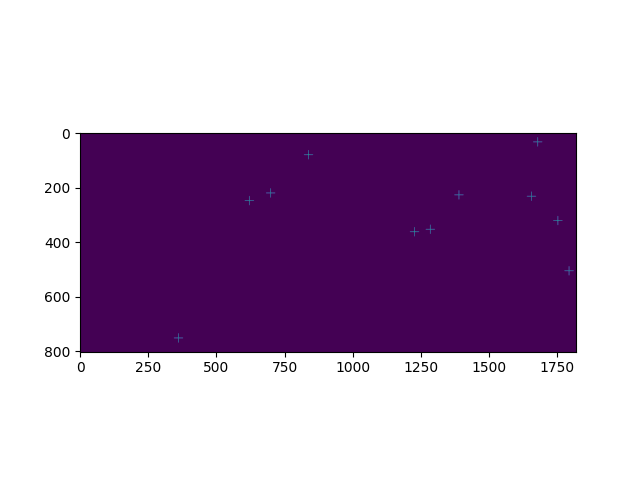

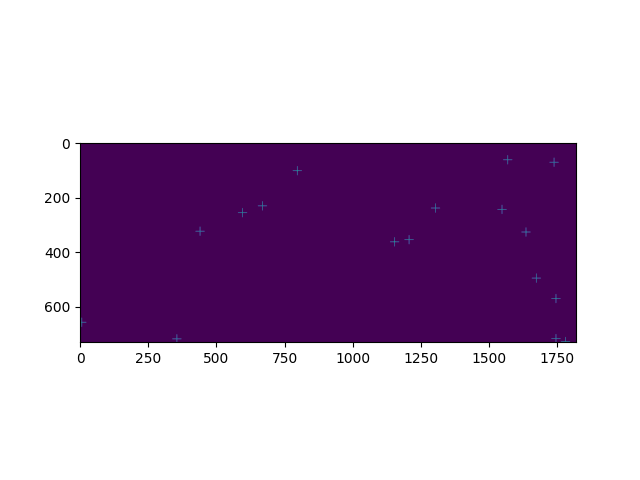

In [21]:
Plot_length = 16
image_copy = IMAGES[0].copy()
for star in STARS[0]:
    image_copy[max([round(star[1])-Plot_length, 0]) : min([round(star[1])+Plot_length+1, image_copy.shape[0]]),  round(star[2])] = 1
    image_copy[round(star[1]), max([round(star[2])-Plot_length, 0]) : min([round(star[2])+Plot_length+1, image_copy.shape[1]])] = 1
plt.figure(4)
plt.imshow(image_copy)
plt.show()

### Sorting the stars based on size

In [7]:
for image_no in range(len(STARS)):
    STARS[image_no] = STARS[image_no][np.argsort(STARS[image_no][:,0])[::-1],:]

### Forming the triangles

In [29]:
Num_stars = 10

def Compute_dist(point1, point2):
    return np.sqrt( (point1[0]-point2[0])**2 + (point1[1]-point2[1])**2 )

TRIANGLES = []
TRIANGLE_VERTICES = []
for image_no in range(len(IMAGES)):
    stars_copy = STARS[image_no][:min([Num_stars, STARS[image_no].shape[0]]),:]
    triangles = []
    triangle_vertices = []

    Triangle_vertex_indices = np.array([0,1,2], dtype=np.int_)
    while(Triangle_vertex_indices[0]<stars_copy.shape[0]):
        Triangle_vertex_indices[1] = Triangle_vertex_indices[0]+1
        while(Triangle_vertex_indices[1]<stars_copy.shape[0]):
            Triangle_vertex_indices[2] = Triangle_vertex_indices[1]+1
            while(Triangle_vertex_indices[2]<stars_copy.shape[0]):
                


                # List of stars
                star_array = np.array([stars_copy[Triangle_vertex_indices[0],1:], stars_copy[Triangle_vertex_indices[1],1:], stars_copy[Triangle_vertex_indices[2],1:]])
                
                # Compute array of sides
                Side1 = Compute_dist(star_array[0], star_array[1])
                Side2 = Compute_dist(star_array[1], star_array[2])
                Side3 = Compute_dist(star_array[2], star_array[0])    
                Side_array = np.array([Side1, Side2, Side3])


                # Sort stars based on side order
                """
                SIDE order to STAR order
                0 1 2 --- 0 1 2
                1 0 2 --- 2 1 0
                1 2 0 --- 1 2 0
                2 1 0 --- 0 2 1
                2 0 1 --- 2 0 1
                0 2 1 --- 1 0 2
                """
                Star_sort_indices = np.argsort(Side_array)
                if( ((Star_sort_indices[1] - Star_sort_indices[0]) == -1) or ((Star_sort_indices[2] - Star_sort_indices[1]) == -1) ):
                    Star_sort_indices = np.mod(Star_sort_indices+1,3)

                # Append
                triangle_vertices.append(star_array[Star_sort_indices])
                triangles.append(np.sort(Side_array))


                Triangle_vertex_indices[2] += 1
            Triangle_vertex_indices[1] += 1
        Triangle_vertex_indices[0] += 1
    TRIANGLES.append(np.array(triangles))
    TRIANGLE_VERTICES.append(triangle_vertices)

### Triangle matching

In [30]:
SIMILARITY_MAP = triangle_matching_fn(TRIANGLES,one_to_one=False)

### Computing AFFINEs of all matched  triangles
### Then taking mode

In [31]:
Mode_bins = 20

def compute_AFFINE(Points1, Points2):
    Mat = np.linalg.inv(np.concatenate((Points1, np.array([[1],[1],[1]])), axis=1))
    return np.reshape(Mat @ Points2, (6))

TRANSFORMS = []
for image_no in range(len(IMAGES)):
    transforms = []
    Mode = []
    
    for index in range(SIMILARITY_MAP[image_no].shape[0]):
        transforms.append(cv2.getAffineTransform(np.float32(TRIANGLE_VERTICES[image_no][index]), np.float32(TRIANGLE_VERTICES[0][int(SIMILARITY_MAP[image_no][index])])).reshape((6)))
        #transforms.append(compute_AFFINE(TRIANGLE_VERTICES[image_no][index], TRIANGLE_VERTICES[0][int(SIMILARITY_MAP[image_no][index])]))
    transforms = np.array(transforms)

    for index in range(6):
        freq, bins = np.histogram(transforms[:,index], bins=Mode_bins)
        Mode.append( (bins[np.argmax(freq)] + bins[np.argmax(freq)+1])/2 )
    TRANSFORMS.append(np.array(Mode))

In [32]:
OUTPUT_IMAGES = []
for index in range(len(IMAGES)):
    OUTPUT_IMAGES.append(cv2.warpAffine(IMAGES[index], TRANSFORMS[index].reshape((2,3)), (IMAGES[0].shape[::-1])))

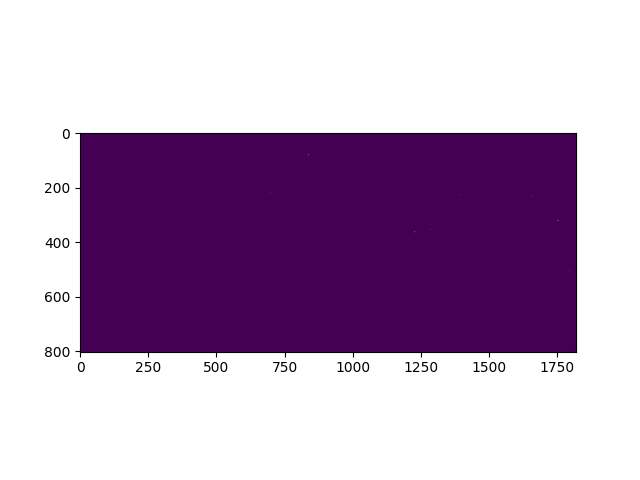

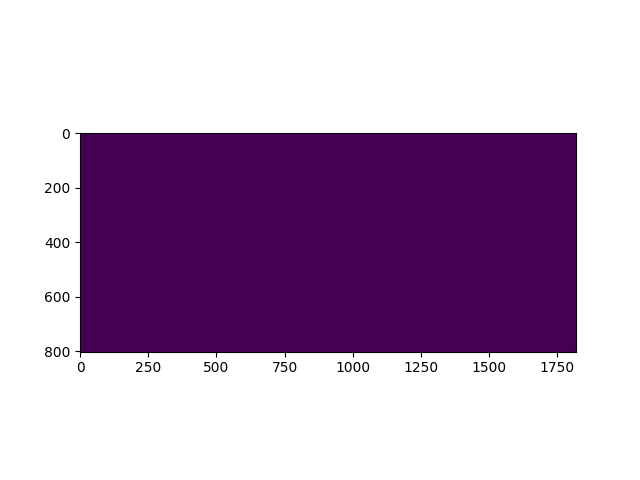

In [33]:
plt.figure(5)
plt.imshow(OUTPUT_IMAGES[0])
plt.show()

plt.figure(6)
plt.imshow(OUTPUT_IMAGES[1])
plt.show()


In [34]:
freq, bins

(array([ 1,  0,  0,  1,  1,  1,  4,  6,  6, 31, 21,  9, 17, 11,  2,  4,  1,
         1,  1,  2], dtype=int64),
 array([-6303.51449062, -5635.84953045, -4968.18457028, -4300.51961011,
        -3632.85464994, -2965.18968977, -2297.5247296 , -1629.85976943,
         -962.19480926,  -294.52984909,   373.13511108,  1040.80007125,
         1708.46503142,  2376.12999159,  3043.79495176,  3711.45991192,
         4379.12487209,  5046.78983226,  5714.45479243,  6382.1197526 ,
         7049.78471277]))

In [35]:
TRANSFORMS

[array([ 1.00000000e+00, -2.70377251e-16,  4.25393891e-13, -4.35164456e-17,
         1.00000000e+00, -1.57638273e-14]),
 array([ 4.78717766e-01,  5.94117238e-02, -9.93102562e+01,  4.03688992e-01,
         3.85639089e-01,  3.93026310e+01])]

In [36]:
TRANSFORMS

[array([ 1.00000000e+00, -2.70377251e-16,  4.25393891e-13, -4.35164456e-17,
         1.00000000e+00, -1.57638273e-14]),
 array([ 4.78717766e-01,  5.94117238e-02, -9.93102562e+01,  4.03688992e-01,
         3.85639089e-01,  3.93026310e+01])]

In [37]:
TRANSFORMS[0].reshape((2,3))

array([[ 1.00000000e+00, -2.70377251e-16,  4.25393891e-13],
       [-4.35164456e-17,  1.00000000e+00, -1.57638273e-14]])

In [41]:
i=0
print(SIMILARITY_MAP[1][i])
print(TRIANGLES[1][i])
print(TRIANGLES[0][int(SIMILARITY_MAP[1][i])])


0.0
[441.88048816 483.74967854 868.85814047]
[480.8480636  527.24624993 946.30676943]
